In [1]:
import pandas as pd
import numpy as np
import os
import datetime 
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

In [2]:
## set the period of forcast start from 2015 to 2023
start_mth = datetime.datetime(2016, 1, 1)
end_mth = datetime.datetime(2023, 12, 1)

## set up directory
os.chdir('C:\\Users\\Windows\\Documents\\2.Project\\4.Energy\\2.Electricity Price and Demand\\1.Data Set')

## read file
usage = pd.read_csv('NSW_Price_Demand.csv', sep=',')
usage.columns = usage.columns.str.lower()

## convert column type
selected_col = ['settlementdate','totaldemand','rrp']
usage = usage[selected_col]

usage['settlementdate'] = pd.to_datetime(usage['settlementdate'])
usage['day'] = usage['settlementdate'].dt.day
usage['month'] = usage['settlementdate'].dt.month
usage['year'] = usage['settlementdate'].dt.year

usage['totaldemand'] = usage['totaldemand'].astype(float)
usage['rrp'] = usage['rrp'].astype(float)

usage.index = usage.settlementdate
print(usage.info())
print(usage.head(2))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 390096 entries, 2013-01-01 00:30:00 to 2024-01-01 00:00:00
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   settlementdate  390096 non-null  datetime64[ns]
 1   totaldemand     390096 non-null  float64       
 2   rrp             390096 non-null  float64       
 3   day             390096 non-null  int64         
 4   month           390096 non-null  int64         
 5   year            390096 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 20.8 MB
None
                         settlementdate  totaldemand    rrp  day  month  year
settlementdate                                                               
2013-01-01 00:30:00 2013-01-01 00:30:00      7166.97  46.61    1      1  2013
2013-01-01 01:00:00 2013-01-01 01:00:00      6928.11  46.32    1      1  2013


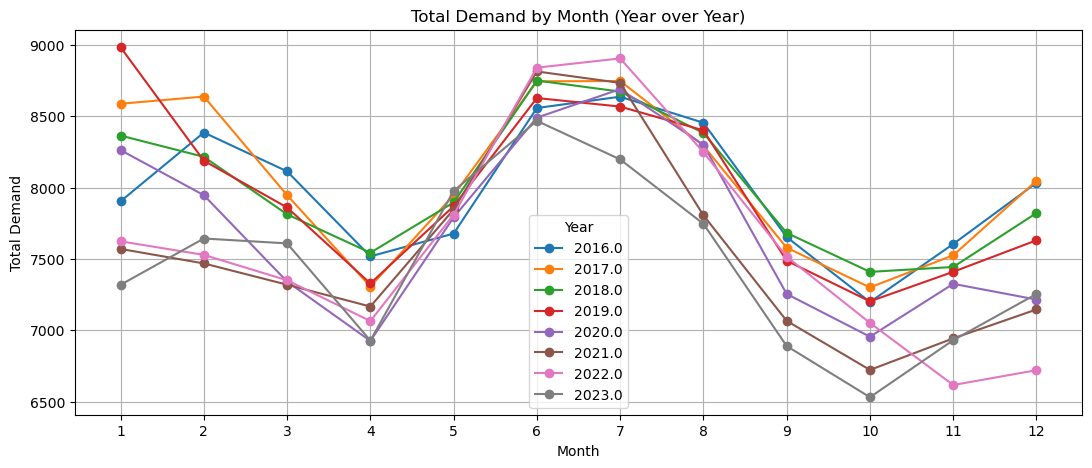

In [3]:
## data preparation
## Filter usage within start and end month
usage = usage[( usage['settlementdate']>=start_mth) & (usage['settlementdate'] <= end_mth)]

## sum average daily demand by month
usage.index = usage.settlementdate
usage_mth = usage.resample('M').mean()

### plot data - mean usage per month
# Pivot the DataFrame to have years as columns and months as index
pivot_df = usage_mth.pivot_table(index='month', columns='year', values='totaldemand')

# Plot the line chart
pivot_df.plot(kind='line', marker='o', figsize=(13, 5))
plt.title('Total Demand by Month (Year over Year)')
plt.xlabel('Month')
plt.ylabel('Total Demand')
plt.xticks(range(1, 13))  
plt.grid(True)
plt.legend(title='Year', loc='best')
plt.show()

In [4]:
## Check if time series data is stationary
# Test using statsmodels adfuller
def df_test(time_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)
    
# apply the function to the dataset
df_test(usage_mth.totaldemand)

Results of Dickey-Fuller Test:
Test Statistic                 -0.514347
p-value                         0.889186
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


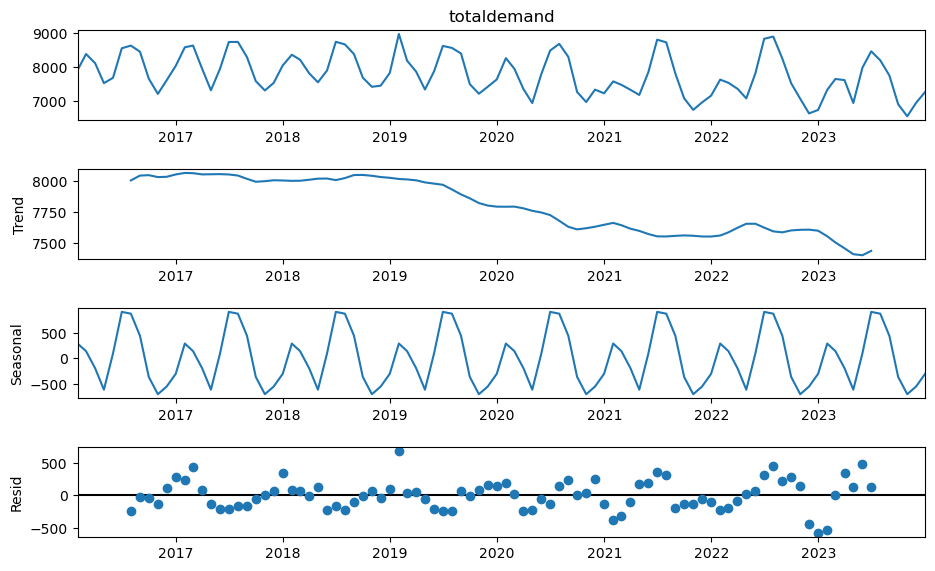

In [5]:
# Check the time series trend, seasonality and residuals (noise component) and analyze.
decomp = seasonal_decompose(usage_mth.totaldemand)
fig = decomp.plot()
fig.set_size_inches(10,6)

In [6]:
## data processing for model
forecast_mths = 12 ## set the forecast next 12 months
usage_mth['ds'] = usage_mth.index

train = usage_mth[ : -forecast_mths]
test = usage_mth[-forecast_mths :]

y_train = train['totaldemand']
y_test = test['totaldemand']

print('Train size: ' + str(train.shape[0]) +   ' , Test size: ' + str(test.shape[0]))

Train size: 84 , Test size: 12


c:\Users\Windows\miniconda3\envs\datascience_37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=994.151, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=999.954, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=998.727, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=995.190, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=993.739, Time=0.06 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=992.818, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=993.771, Time=0.37 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=994.702, Time=0.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=994.666, Time=0.24 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=990.213, Time=0.67 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=990.178, Time=0.16 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=993.248, Time=0.09 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=991.956, Time=0.17 sec
 ARIMA(1,1,1)(1,1,2)[12]             

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.30 sec

Best model:  ARIMA(1,1,1)(0,1,1)[12]          
Total fit time: 4.774 seconds


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Holt Winter
Mean Absolute Percentage Error (MAPE) : 7.89%
Root Mean Square Error : 680.0520517551555
ARIMAX
Mean Absolute Percentage Error (MAPE) : 3.92%
Root Mean Square Error : 327.94541579928256
Prophet
Mean Absolute Percentage Error (MAPE) : 2.89%
Root Mean Square Error : 269.28439673681964


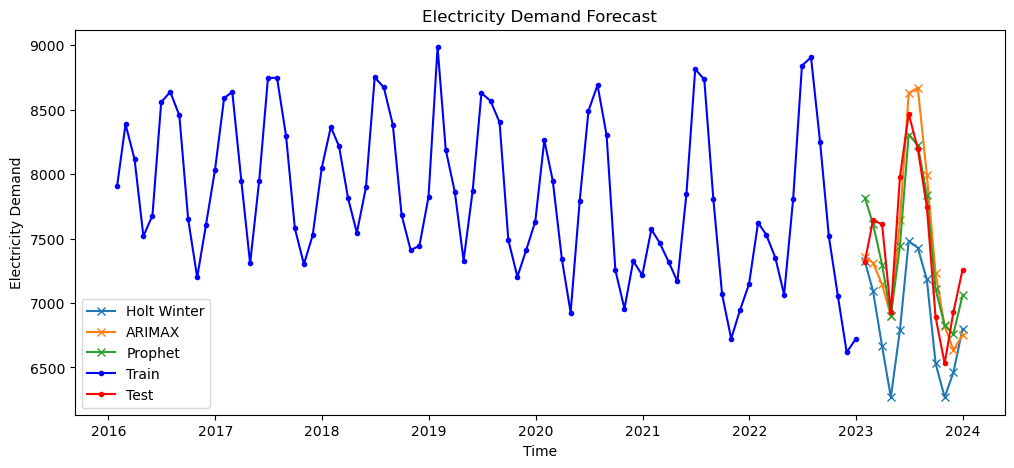

In [13]:
## forecast the monthly usage
## 1. Holt Winter Forecast
hw_model = ExponentialSmoothing(y_train, seasonal_periods = 12, trend ='mul', seasonal = 'mul')
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(len(y_test))

## 3.2 ARIMAX Forecast 
## Find the best arimax
sarimax_model = auto_arima(y_train, start_p = 0, start_q = 0
                                ,max_p = 3, max_q = 3
                                , m = 12 #12 is the frequncy of the cycle
                                , test = 'adf', seasonal = True #set to seasonal
                                , d=1, D=1, trace = True, error_action = 'ignore'
                                , suppress_warnings = True, stepwise = True)

model_order = sarimax_model.get_params()['order']
model_seasonal_order = sarimax_model.get_params()['seasonal_order']

sr_model = SARIMAX(y_train, order = model_order, seasonal_order = model_seasonal_order)
sr_model_fit = sr_model.fit()
# print(sarimax_model_fit.summary()) ## uncomment this line to review model summary

sr_pred = sr_model_fit.forecast(len(y_test))

# # 3.3 Phophet Model
# ## data processing for model
p_train = train[['ds', 'totaldemand']]
p_train.columns = ['ds','y']

## Prophet model
pp_model = Prophet()
pp_model.fit(p_train)
pp_pred = pp_model.make_future_dataframe(periods=len(y_test), freq='M')
pp_pred = pp_model.predict(pp_pred)
pp_pred.index = pp_pred.ds
pp_pred = pp_pred.iloc[-len(y_test):, ]['yhat'].values

## Calculate Mean Absolute Percentage Error and Root Mean Square Error
def accuracy(y_test, y_pred):
    mape = np.mean(np.abs(( y_test - y_pred) / y_test)*100)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2 ))
    return(mape, rmse)

## Review the result from model
models = {
    'Holt Winter': hw_pred
    ,'ARIMAX': sr_pred
    ,'Prophet': pp_pred
}

plt.figure(figsize=(12,5))

for name, y_pred in models.items():
    mape, rmse = accuracy(y_test, y_pred)
    print('================================================================')
    print(name)
    print('Mean Absolute Percentage Error (MAPE) : {:.2f}%'.format(mape))
    print('Root Mean Square Error : {}'.format(rmse))
    
    # Plot forecast
    plt.plot(test.index, y_pred, 'x-', label=name)  # Predictions

plt.plot(train.index, y_train, 'b.-', label='Train')  # Train data
plt.plot(test.index, y_test, 'r.-', label='Test')  # Test data
plt.xlabel('Time', fontsize=10)
plt.ylabel('Electricity Demand', fontsize=10)
plt.legend(loc='best')
plt.title('Electricity Demand Forecast', fontsize=12)
plt.show()
